<a href="https://colab.research.google.com/github/zackjsorensen/CS235/blob/main/notebooks/neo4j_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Go to <a href="https://sandbox.neo4j.com/">neo4j Sandbox<a>  

- Create an account and start a Sandbox instance, select the "Movies" option.
- Click the little **black arrow on the far right** of the Sandbox instance.
- Click the "Connection details" tab.
- Copy the **bolt URL**, **username**, and password to the variables below.
- Do not do the movies tutorial **yet**, there will be instructions for that later.

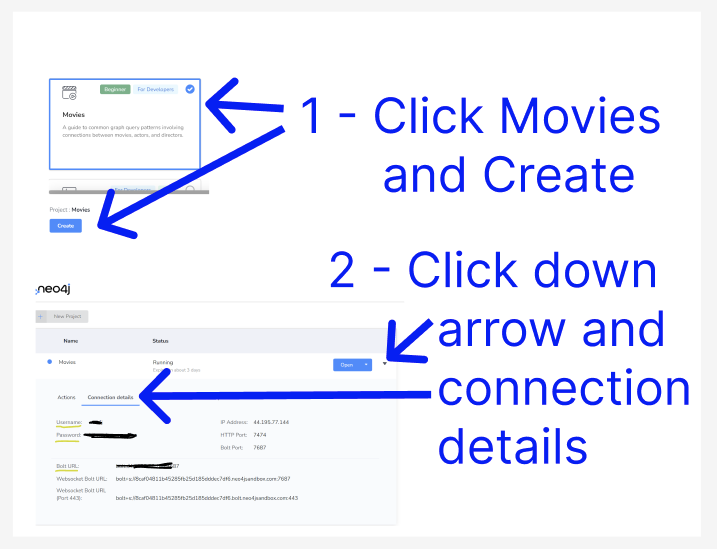

In [23]:
# (Run this and read to understand)
# Enter values!

uri = "neo4j+s://0cf316a8e877a2c78b258bbec975f844.bolt.neo4jsandbox.com:443"
user = "zackjsorensen"
pwd = "zka2CRA7vjc1txz!nua"

if uri == "<PUT THE BOLT URL HERE>" or user == "<PUT USER HERE>" or pwd == "<PUT PASSWORD HERE>":
     raise ValueError('PLEASE CHANGE THE VALUES SO YOU CAN CONNECT TO THE DATABASE!')


In [21]:
!pip3 install neo4j-driver

In [24]:
from neo4j import GraphDatabase, basic_auth
import pandas as pd
from tqdm import tqdm
import ast
import time
import matplotlib.pyplot as plt

In [25]:
# (Run this and read to understand)
# this creates the connection to the database, and
# defines a function to run a query on the database
class Neo4jConnection:

    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):
        if self.__driver is not None:
            self.__driver.close()

    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

conn = Neo4jConnection(uri=uri,
                       user=user,
                       pwd=pwd)
print(conn)

In [26]:
# (Run this and read to understand)
# This is just a test query to make sure your connection is working! If you don't get an error, then it worked!

query_string = '''
MATCH (keanu:Person {name: "Keanu Reeves"})-[:ACTED_IN]->(keanuMovies) RETURN keanuMovies.title AS title, keanuMovies.released AS year
'''

query_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(query_df)

ERROR:neo4j.pool:Unable to retrieve routing information


Query failed: Unable to retrieve routing information


TypeError: 'NoneType' object is not iterable

# Part 1: Run through the movies tutorial!

- Go back to the neo4j Sandbox website and click the blue "Open" button.
- A connection form should pop up, if not type ":server connect" into the command line.
- Connect by either:
 - Using the integrated id like Google Account or
 - Click the "Authentication type" drop down menu, and select "Username/Password". Put the same password in from the Sandbox "Connection details" screen that we used to connect here in colab, and then run the command.
- Type ":play movies" into the command line and go through the tutorial
- Skip the "Create" step on slide 2, the movie data should already be loaded into the database. Or if you did it and got the error just continue!
- Find the Bacon path for Nora Ephron and take a screenshot.

**Pass off requirement:** Save an image of the graph of the Bacon Path for **Nora Ephron** using the Movies dataset. A screen shot from the Neo4j Browser with the graph is sufficient.

# Part 2: ArXiv Tutorial
- You can read the through the tutorial.
- Note: most of the code is already pasted here and some of the code in the tutorial uses a deprecated cipher syntax.
- https://towardsdatascience.com/create-a-graph-database-in-neo4j-using-python-4172d40f89c4


In [ ]:
# Download part of the 4 gig file from the tutorial
!curl -L "https://github.com/byu-cs-452/byu-cs-452-class-content/raw/main/bigdata/metadata.csv" > metadata.csv

In [ ]:
# Read the data in from a csv file
df = pd.read_csv("metadata.csv")

In [ ]:
# View sample data from raw csv and scroll to the right to note authors and categories.
df.head()

In [ ]:
# (Run this and read to understand)
# Cleanup the data in python ahead of time

def get_author_list(line):
    # Cleans author dataframe column, creating a list of authors in the row.
    line = ast.literal_eval(line)
    return [e[1] + ' ' + e[0] for e in line]


def get_category_list(line):
    # Cleans category dataframe column, creating a list of categories in the row.
    return list(line.split(" "))


df['cleaned_authors_list'] = df['authors_parsed'].map(get_author_list)
df['category_list'] = df['categories'].map(get_category_list)
df = df.drop(['Unnamed: 0', 'submitter', 'authors',
             'comments', 'journal-ref',
             'doi', 'report-no', 'license',
             'versions', 'update_date',
             'abstract', 'authors_parsed',
             'categories'], axis=1)

In [ ]:
# Run this to see some data samples of our cleaned up data!
df.head()

In [ ]:
# (Run this and read to understand)
# Create some constraints to ensure the nodes aren't duplicates
conn.query('CREATE CONSTRAINT papers IF NOT EXISTS FOR (p:Paper) REQUIRE p.id IS UNIQUE')
conn.query('CREATE CONSTRAINT authors IF NOT EXISTS FOR (a:Author) REQUIRE a.name IS UNIQUE')
conn.query('CREATE CONSTRAINT categories IF NOT EXISTS FOR (c:Category) REQUIRE c.category IS UNIQUE')

In [ ]:
# (Run this and read to understand)
# Define functions for unwinding lists and individual category
# and author nodes into the database

def add_categories(categories):
    # Adds category nodes to the Neo4j graph.
    query = '''
            UNWIND $rows AS row
            MERGE (c:Category {category: row.category})
            RETURN count(*) as total
            '''
    return conn.query(query, parameters = {'rows':categories.to_dict('records')})


def add_authors(rows, batch_size=10000):
    # Adds author nodes to the Neo4j graph as a batch job.
    query = '''
            UNWIND $rows AS row
            MERGE (:Author {name: row.author})
            RETURN count(*) as total
            '''
    return insert_data(query, rows, batch_size)


def insert_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.

    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query,
                         parameters = {'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total,
                  "batches":batch,
                  "time":time.time()-start}
        print(result)

    return result

In [ ]:
# (Run this and read to understand)
# add papers and link from papers to categories and from authors to papers

def add_papers(rows, batch_size=5000):
   # Adds paper nodes and (:Author)--(:Paper) and
   # (:Paper)--(:Category) relationships to the Neo4j graph as a
   # batch job.

   query = '''
   UNWIND $rows as row
   MERGE (p:Paper {id:row.id}) ON CREATE SET p.title = row.title

   // connect categories
   WITH row, p
   UNWIND row.category_list AS category_name
   MATCH (c:Category {category: category_name})
   MERGE (p)-[:IN_CATEGORY]->(c)

   // connect authors
   WITH distinct row, p // reduce cardinality
   UNWIND row.cleaned_authors_list AS author
   MATCH (a:Author {name: author})
   MERGE (a)-[:AUTHORED]->(p)
   RETURN count(distinct p) as total
   '''

   return insert_data(query, rows, batch_size)

In [ ]:
# (Run this and read to understand)
# inserts the data in batches

categories = pd.DataFrame(df[['category_list']])
categories.rename(columns={'category_list':'category'},
                  inplace=True)
categories = categories.explode('category') \
                       .drop_duplicates(subset=['category'])

authors = pd.DataFrame(df[['cleaned_authors_list']])
authors.rename(columns={'cleaned_authors_list':'author'},
               inplace=True)
authors=authors.explode('author').drop_duplicates(subset=['author'])

add_categories(categories)
add_authors(authors)
add_papers(df)

#Go to your https://sandbox.neo4j.com browser and query your graph!
- Run the query from the tutorial in the neo4j browser to generate a graph chart of the first 300 nodes:
 - `MATCH (a:Author)-[:AUTHORED]->(p:Paper)-[:IN_CATEGORY]->(c:Category) RETURN a, p, c LIMIT 300`
   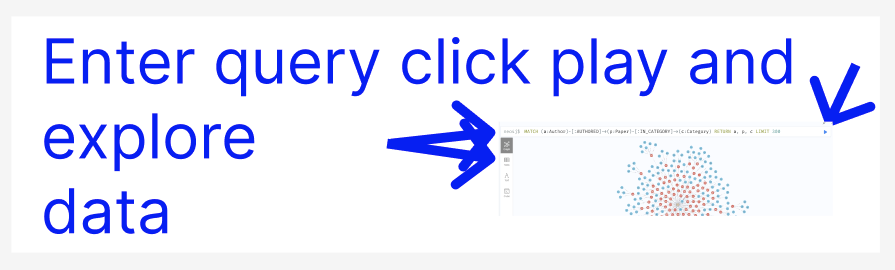
- Try another using the "where" clause to limit to "CS" papers:

`
    MATCH (a:Author)-[:AUTHORED]->(p:Paper)-[:IN_CATEGORY]->(c:Category)  
    RETURN a, p, c limit 50  
    union all  
    MATCH (a:Author)-[:AUTHORED]->(p:Paper)-[:IN_CATEGORY]->(c:Category)   
    where c.category starts with "cs"  
    RETURN a, p, c limit 50  
`
 - Try dragging the center node around :)
 - Explain to someone what this query asks and show them what the resulting graph looks like:
`
    MATCH (c:Category)--(p2:Paper)--(a2:Author)--(p3:Paper)--(c2:Category)
    where c<>c2
    RETURN c,p2,a2,p3,c2 limit 300
`

In [ ]:
# (Run this and read to understand)
# List the count of papers in each category!

query_string = '''
MATCH (c:Category)
RETURN c.category, apoc.node.degree(c, "<IN_CATEGORY") AS inDegree
ORDER BY inDegree DESC LIMIT 20
'''

top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
top_cat_df.head(20)

In [ ]:
# (Run this and read to understand)
# Graph it in a bar plot
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
top_cat_df.plot.bar(y = "inDegree", x = "c.category", xlabel="", title="Papers in Categories", legend=None, color=plt.cm.Pastel1(np.arange(8)))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Can you show the indegree of just computer science type category papers?

# YOUR CODE HERE


In [ ]:
# Write an aggregate query to count all papers
# https://neo4j.com/docs/cypher-manual/current/functions/aggregating/

# YOUR CODE HERE


In [ ]:
# Write a query to sum or count the total number of papers in CS type categories

# YOUR CODE HERE
